In [9]:
import os
import numpy as np
import math
import h5py
import pandas as pd
import pickle
import matplotlib.lines as mlines
import utils
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import concurrent.futures
import glob
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

# User Defend Variables

In [196]:
# important arguments
filename = 'VJ_OFCVTA_7_260_D6'
root_dir = r'C:\Users\Public\Documents\2p_data\VJ_OFCVTA_7_D8_trained' # os.path.abspath("data_2p/full_session-000/")

analysis_win = [0, None]
raw_npilCorr = 1 # 0 for raw vs 1 neuropil corrected signal
fs = 5

rois_to_include = None
activity_name = True

In [197]:
fparams = {}
fparams['fs'] = 5 #sampling rate
fparams['trial_start_end'] = [-2, 8] # [start, end] times (in seconds) included in the visualization 
fparams['baseline_end'] = -0.2 # baseline epoch end time (in seconds) for performing baseline normalization
fparams['selected_conditions'] = None 

fparams['fname_signal'] = 'VJ_OFCVTA_7_260_D6_neuropil_corrected_signals_15_50_beta_0.8.npy'
fparams['fname_events'] = 'event_times_VJ_OFCVTA_7_260_D6_trained.csv'
fparams['fdir'] = os.path.abspath('./sample_data/VJ_OFCVTA_7_260_D6')

In [198]:
### create variables that reference samples and times for slicing and plotting the data
signals_fpath = os.path.join(fparams['fdir'], fparams['fname_signal'])
events_file_path = os.path.join(fparams['fdir'], fparams['fname_events'])

trial_start_end_sec = np.array(fparams['trial_start_end']) # trial windowing in seconds relative to ttl-onset/trial-onset, in seconds
baseline_start_end_sec = np.array([trial_start_end_sec[0], fparams['baseline_end']])

trial_begEnd_samp = trial_start_end_sec*fparams['fs'] # turn trial start/end times to samples
baseline_begEnd_samp = baseline_start_end_sec*fparams['fs']

In [199]:
# Loading signal data
signals = utils.load_signals(signals_fpath)

# Load Data 

In [200]:
# initialize meta variables
sima_h5_path = os.path.join(root_dir, filename + '_sima_mc.h5')

fig_save_dir = os.path.join(root_dir, 'figs')
if not os.path.exists(fig_save_dir):
    os.mkdir(fig_save_dir)

In [201]:
### load behavioral data and trial info
glob_event_files = glob.glob(events_file_path) # look for a file in specified directory
if not glob_event_files:
    print(f'{events_file_path} not detected. Please check if path is correct.')
if 'csv' in glob_event_files[0]:
    event_times = utils.df_to_dict(glob_event_files[0])
elif any(x in glob_event_files[0] for x in ['pkl', 'pickle']):
    event_times = pickle.load( open( glob_event_files[0], "rb" ), fix_imports=True, encoding='latin1' ) # latin1 b/c original pickle made in python 2
event_frames = utils.dict_time_to_samples(event_times, fparams['fs'])

# identify conditions to analyze
all_conditions = event_frames.keys()
conditions = [ condition for condition in all_conditions if len(event_frames[condition]) > 0 ] # keep conditions that have events

conditions.sort()
if fparams['selected_conditions']:
    conditions = fparams['selected_conditions']

In [202]:
# load video data
# open h5 to read, find data key, grab data, then close
h5 = h5py.File(sima_h5_path,'r')
sima_data = np.squeeze(np.array( h5[list(h5.keys())[0]] )).astype('int16') # np.array loads all data into memory
h5.close()

In [203]:
manual_data_dims = sima_data.shape

In [204]:
# grab ROI masks from sima (these are probably manually drawn ROIs from imagej)
sima_mask_path = os.path.join(root_dir, filename+'_sima_masks.npy')

sima_masks = np.load(sima_mask_path)
numROI_sima = sima_masks.shape[0]
if not rois_to_include:
    rois_to_include = np.arange(numROI_sima)
num_rois_to_include = len(rois_to_include)

In [205]:
# make binary array of roi pixels for contour plotting
zero_template_manual = np.zeros([manual_data_dims[1], manual_data_dims[2]])
roi_label_loc_manual = []
roi_signal_sima = np.empty([numROI_sima, sima_data.shape[0]])

for iROI in rois_to_include:
    # make binary map of ROI pixels
    ypix_roi, xpix_roi = np.where(sima_masks[iROI,:,:] == 1)
    if ypix_roi.size == 0:
        roi_label_loc_manual.append( [0, 0] )
    else:
        zero_template_manual[ ypix_roi, xpix_roi ] = 1*(iROI+2)
        roi_label_loc_manual.append( [np.min(ypix_roi), np.min(xpix_roi)] )
        if raw_npilCorr == 0:
            # not npil corr signal
            roi_signal_sima[iROI,:] = np.mean(sima_data[:, ypix_roi, xpix_roi  ], axis = 1)
            roi_signal_sima.shape

In [206]:
# load t-series data
if raw_npilCorr == 1:
    roi_signal_sima = np.load(os.path.join(root_dir, filename+'_neuropil_corrected_signals_15_50_beta_0.8.npy'))
    print(roi_signal_sima.shape)
else:
    roi_signal_sima = np.empty([numROI_sima, sima_data.shape[0]])

(61, 15169)


In [207]:
# initialize variables for plotting time-series
num_samps = roi_signal_sima.shape[-1]
total_time = num_samps/fs 
tvec = np.linspace(0,total_time,num_samps)

In [208]:
# Loading in the pickle file that contains the dictionary which is
# the data of activity values for different events
data_dict = utils.extract_trial_data(signals, tvec, trial_begEnd_samp, event_frames, conditions, baseline_start_end_samp=baseline_begEnd_samp)

In [209]:
roi_signals = np.load(os.path.join(root_dir, filename+'_neuropil_corrected_signals_15_50_beta_0.8.npy'))
vector = np.zeros(len(rois_to_include) + 1, dtype=float)

# for iROI, counter in enumerate(rois_to_include):
#     avg_val = np.mean(roi_signals[iROI:,])
#     baseline = np.max(roi_signals[iROI:,])
#     vector[counter] = (avg_val - np.min(roi_signals[iROI,:])) / baseline * 100
# orig_vector = roi_signals[iROI:,]

In [210]:
# Using multiprocessing to speed up the processing
def calculate_std_chunk(chunk):
    return np.std(chunk, axis=0)

# Split data into chunks for parallel processing
print(len(sima_data))
chunk_size = len(sima_data) // 1000  # Determine an appropriate chunk size
chunks = [sima_data[i:i+chunk_size] for i in range(0, len(sima_data), chunk_size)]

with concurrent.futures.ThreadPoolExecutor() as executor:
    std_chunk_results = executor.map(calculate_std_chunk, chunks)

# Combine the results
std_img = np.std(np.array(list(std_chunk_results)), axis=0)

15169


In [211]:
# set font size for yticks for the upcoming plots
plt.rc('ytick',labelsize=12)

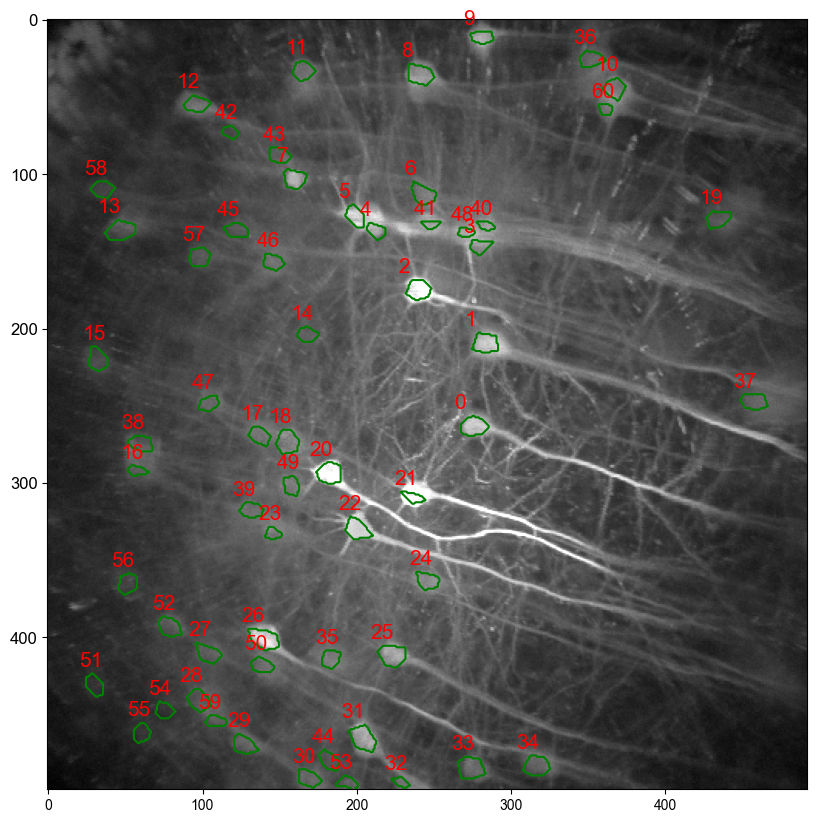

In [212]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
climits = [np.min(std_img), np.max(std_img)]
img = ax.imshow(std_img, cmap = 'gray', vmin = climits[0]*1, vmax = climits[1]*0.8)

for i, iroi in enumerate(rois_to_include):
    cm = plt.contour(sima_masks[iroi,:,:], colors='g')
    plt.text(roi_label_loc_manual[i][1] - 5, roi_label_loc_manual[i][0] - 5,  int(iroi), fontsize=15, color = 'red')

## Event-related Activity Contour plots

In [213]:
# # sample the colormaps that you want to use. Use 128 from each so we get 256
# # colors in total
colors1 = plt.cm.Greens(np.linspace(1, 0, 128))
colors2 = plt.cm.Purples(np.linspace(0, 1, 128))
colors = np.vstack((colors1, colors2))
custom_cmap = mcolors.ListedColormap(colors)

In [214]:
# Creating lists of rgb values
gpcolors = []
colors_list = []

# add the rgb values of a color scheme into the list
for j in range(custom_cmap.N):
    rgba = custom_cmap(j)
    colors_list.append(matplotlib.colors.rgb2hex(rgba))

gpcolors.append(colors_list)

In [215]:
def generate_contour_vectors(data_dict, analysis_win, name):
    sample_tvec = np.linspace(fparams['trial_start_end'][0], fparams['trial_start_end'][1], data_dict[name]['num_samples'])

    if analysis_win[-1] == None:
        analysis_win[-1] = sample_tvec[-1]
    
    # getting the data corresponding to the activity name from the dictionary
    # CZ tvec needs to be an argument in plot_contour, also correct hardcoding of time selection
    contour_vector = np.mean(data_dict[name]
                                      ['zdata']
                                      [:,:,
                                       utils.get_tvec_sample(sample_tvec, analysis_win[0]):utils.get_tvec_sample(sample_tvec, analysis_win[-1])],
                                      axis=(0,2)) 
    
    # making a copy of the original data vector for coloring purposes
    orig_vector = np.copy(contour_vector)
    
    # normalize the values in the vector so that the colors can be properly indexed
    max = 225 / np.max(contour_vector)
    for i in rois_to_include:
        contour_vector[i] = abs(contour_vector[i])
        contour_vector[i] *= max
        if (contour_vector[i] >= 255):
            contour_vector[i] = 255
    
    return contour_vector, orig_vector

In [216]:
def generate_norm_map(vector):
    # Get the min and max of the data ignoring outliers
    percentile_min = np.percentile(vector, 7)
    percentile_max = np.percentile(vector, 93)

    # Generate the data normalization structure
    abs_max = max(np.abs(percentile_min), np.abs(percentile_max))
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=-abs_max, vmax=abs_max)

    # Creating a ScalarMappable for the colorbar
    sm = ScalarMappable(cmap=custom_cmap, norm=norm)
    sm.set_array([])  # Set dummy array for colorbar

    return norm, sm

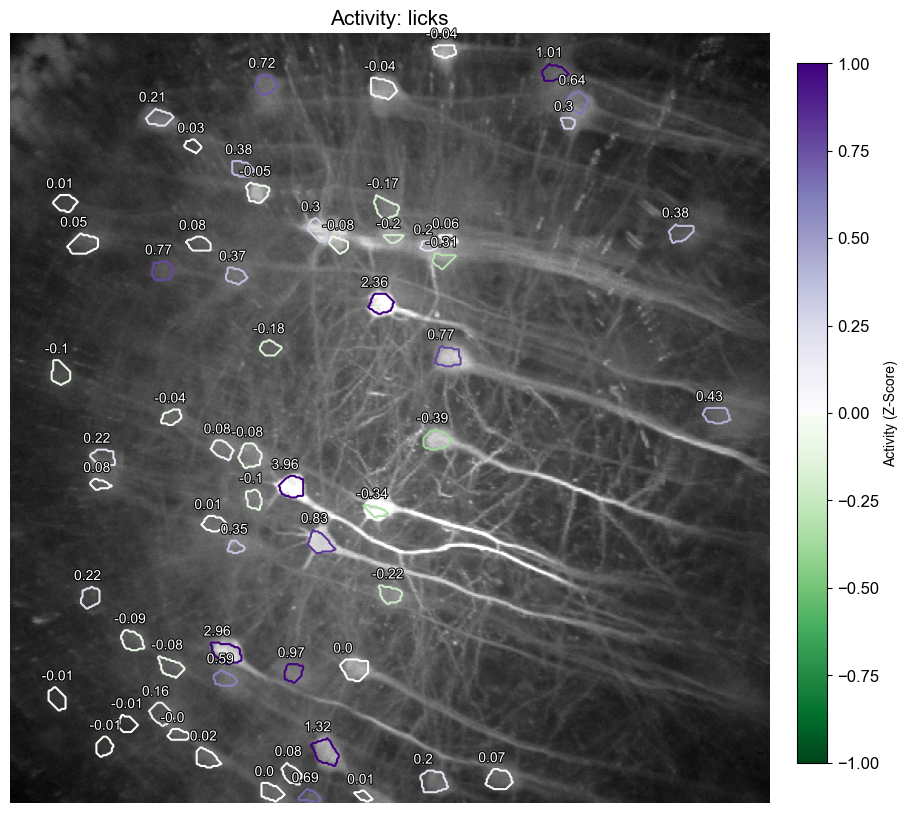

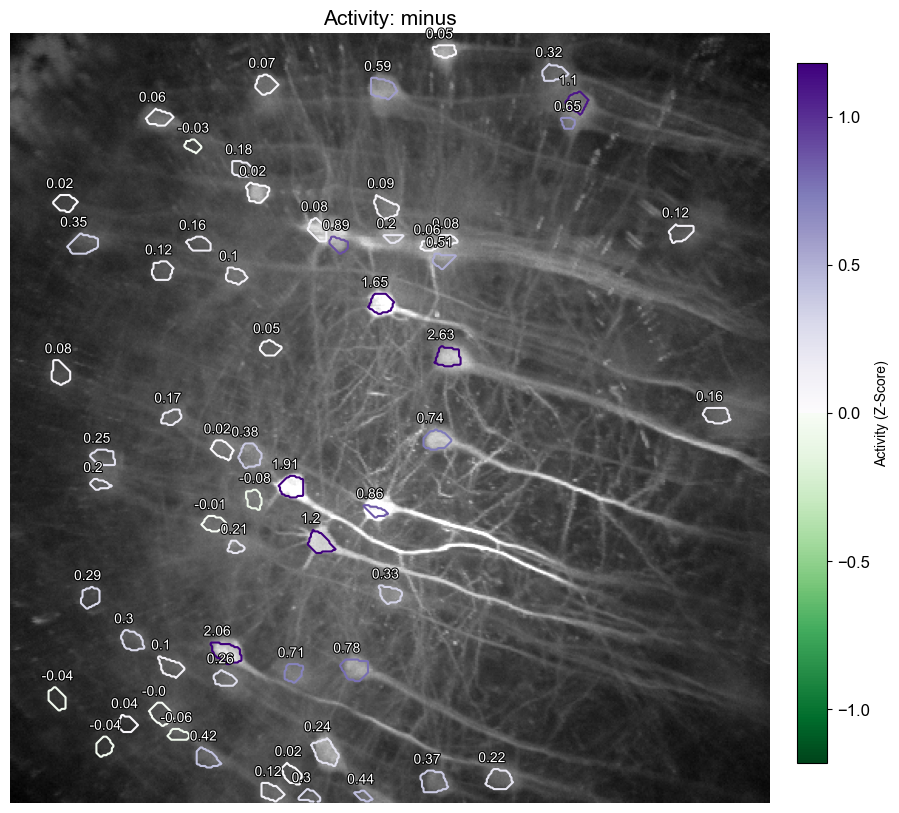

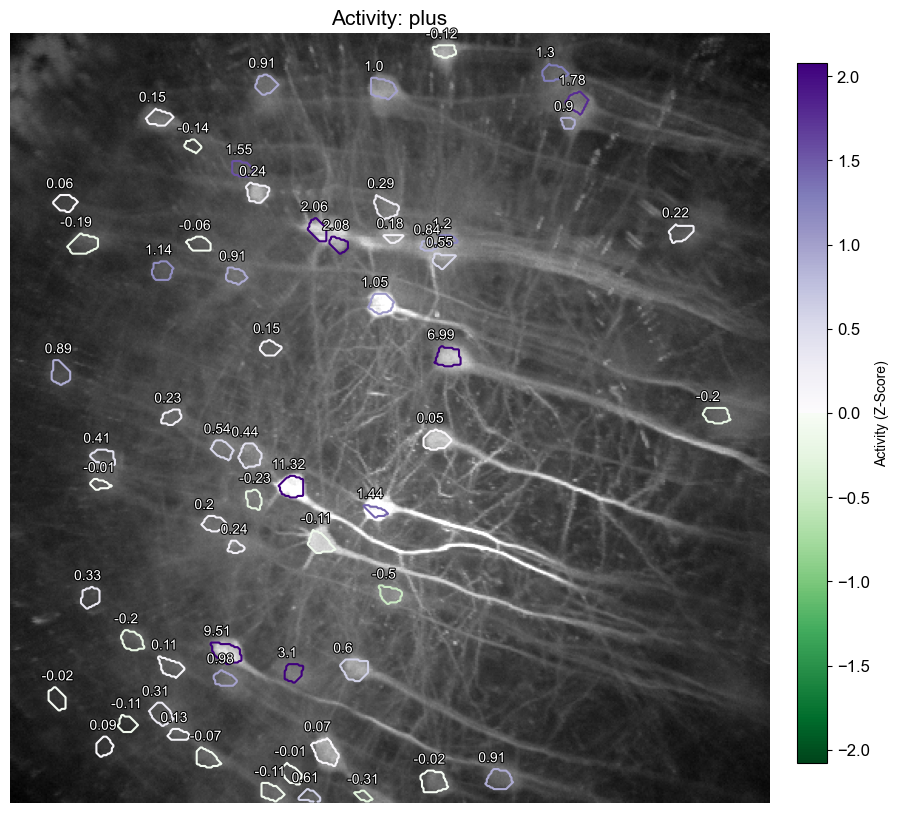

In [217]:
# contour with the activity value instead of the activity name as the label
from matplotlib.colors import ListedColormap

def plot_contour_activityname(name, color_idx):
    """
    A function that takes in a name of an event and a index of the color scheme list as
    parameters and uses the corresponding color schemes to plot the event-based activity contour
    plot using the data fetched from the previously loaded in pickle file
    """
    contour_vector, orig_vector = generate_contour_vectors(data_dict, analysis_win, name)
    norm, sm = generate_norm_map(orig_vector)

    # this all below could be placed into a separate function
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    climits = [np.min(std_img), np.max(std_img)]
    img = ax.imshow(std_img, cmap='gray', vmin=climits[0]*1, vmax=climits[1]*0.8)

    #Adding the ROIs onto the image
    for iroi in range(numROI_sima):
        color = sm.to_rgba(orig_vector[iroi])
        roi_color = color[:3]
        
        # plotting the contours and color them based on each cell's activity value
        cm = plt.contour(sima_masks[iroi,:,:], colors=[roi_color], norm=norm)
        
        # set the data point text label
        if activity_name:
            txt = plt.text(roi_label_loc_manual[iroi][1] - 5, roi_label_loc_manual[iroi][0] - 5, round(orig_vector[iroi], 2), fontsize=10, color='white')
        else:
            txt = plt.text(roi_label_loc_manual[iroi][1] - 5, roi_label_loc_manual[iroi][0] - 5, int(iroi), fontsize=10, color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground='k')])
    
    # Customizing the plot
    plt.title("Activity: " + name, fontsize=15)
    plt.axis('off')

    # Adding colorbar
    cax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust the position as needed
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label("Activity (Z-Score)")

    plt.show()

for i in range(len(conditions)):
   plot_contour_activityname(conditions[i], 0)

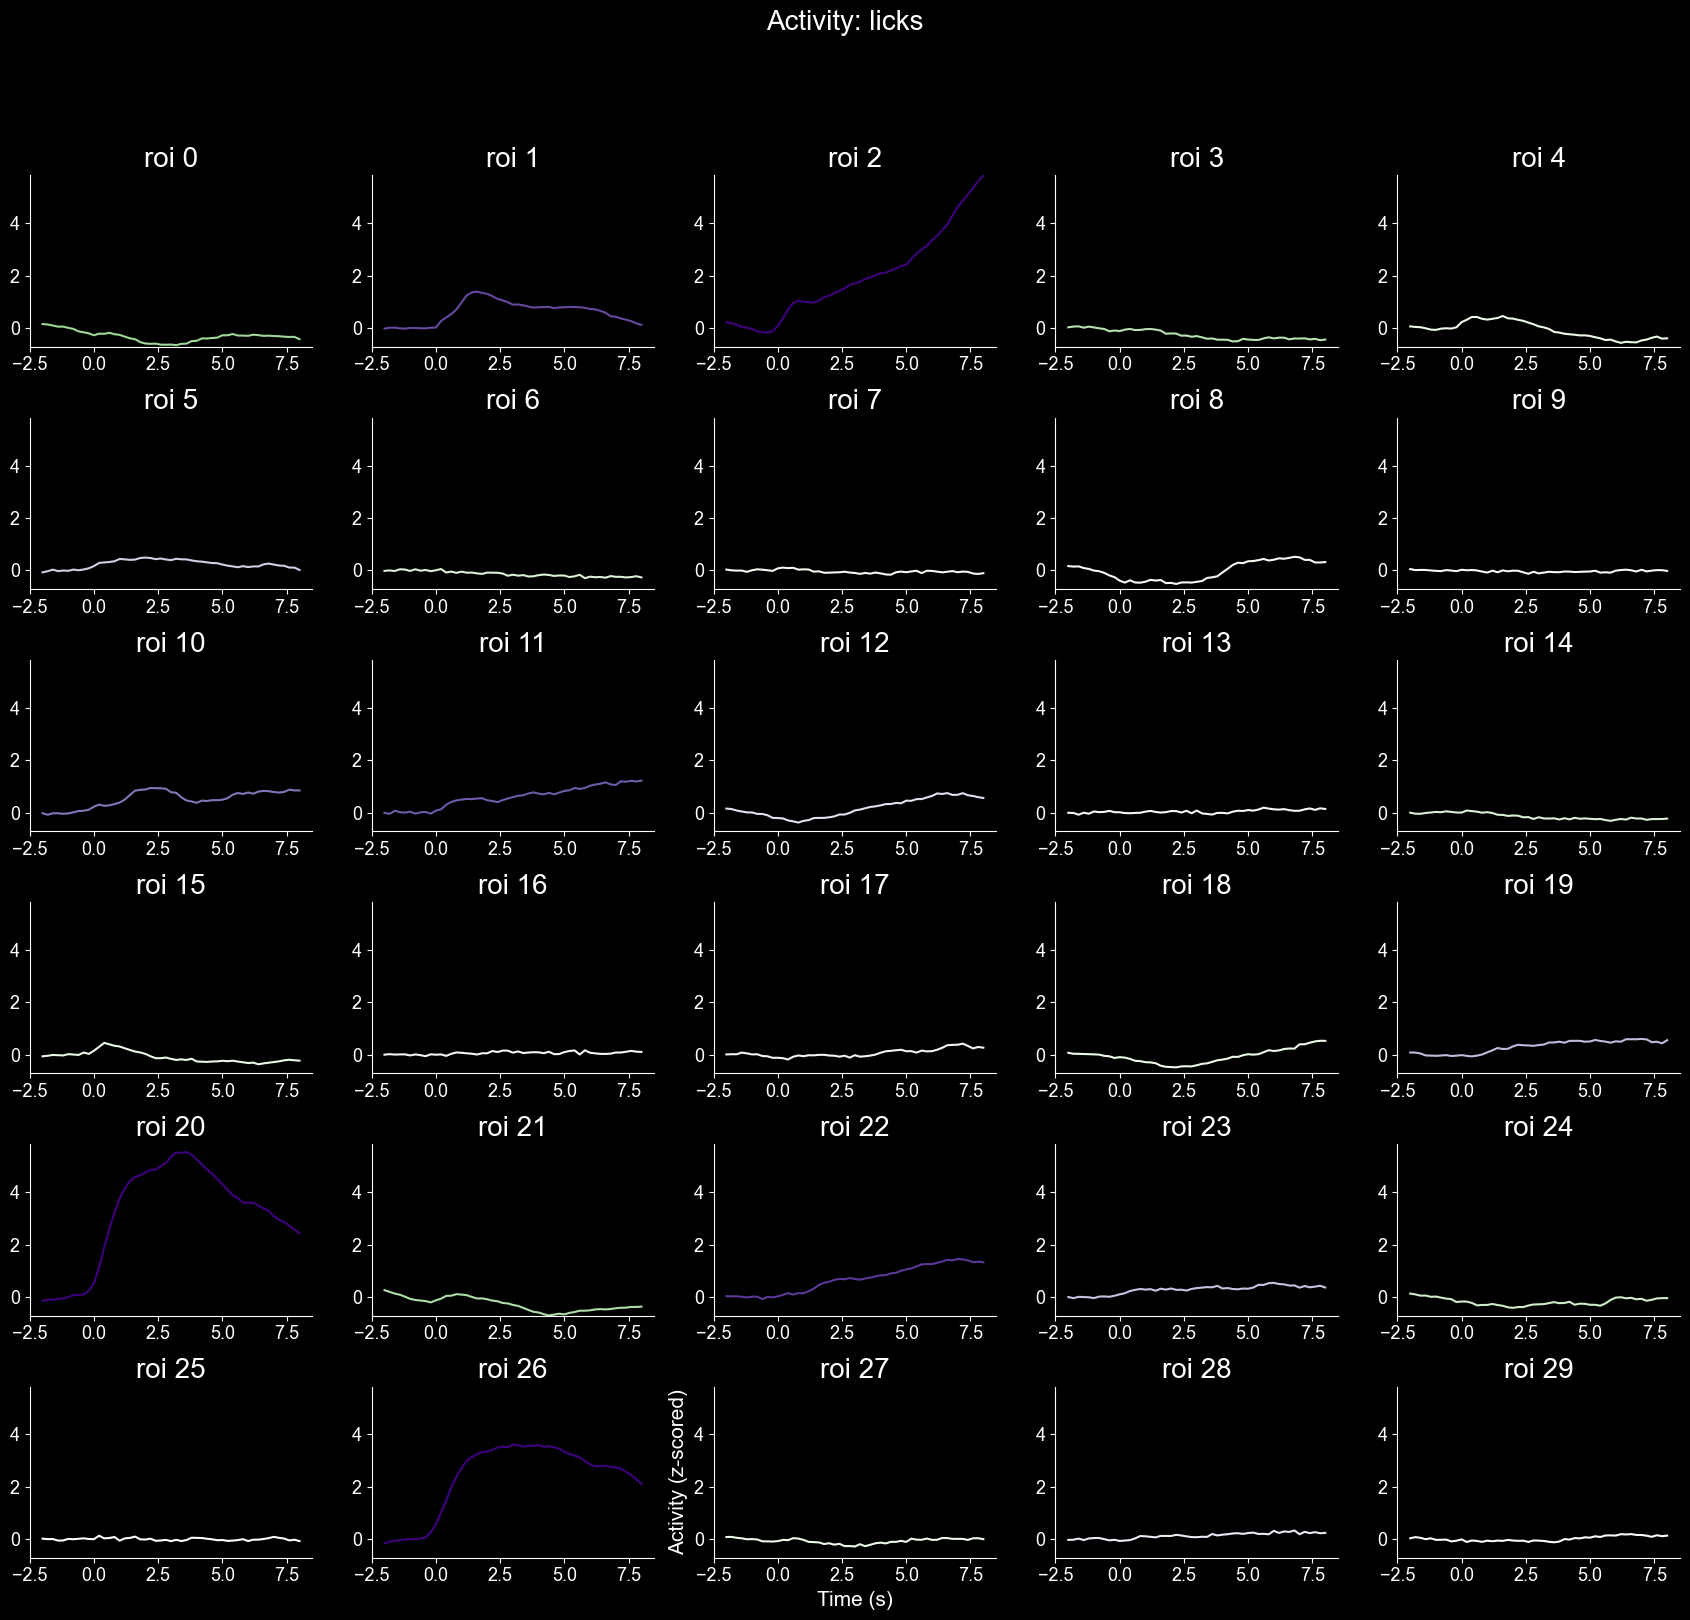

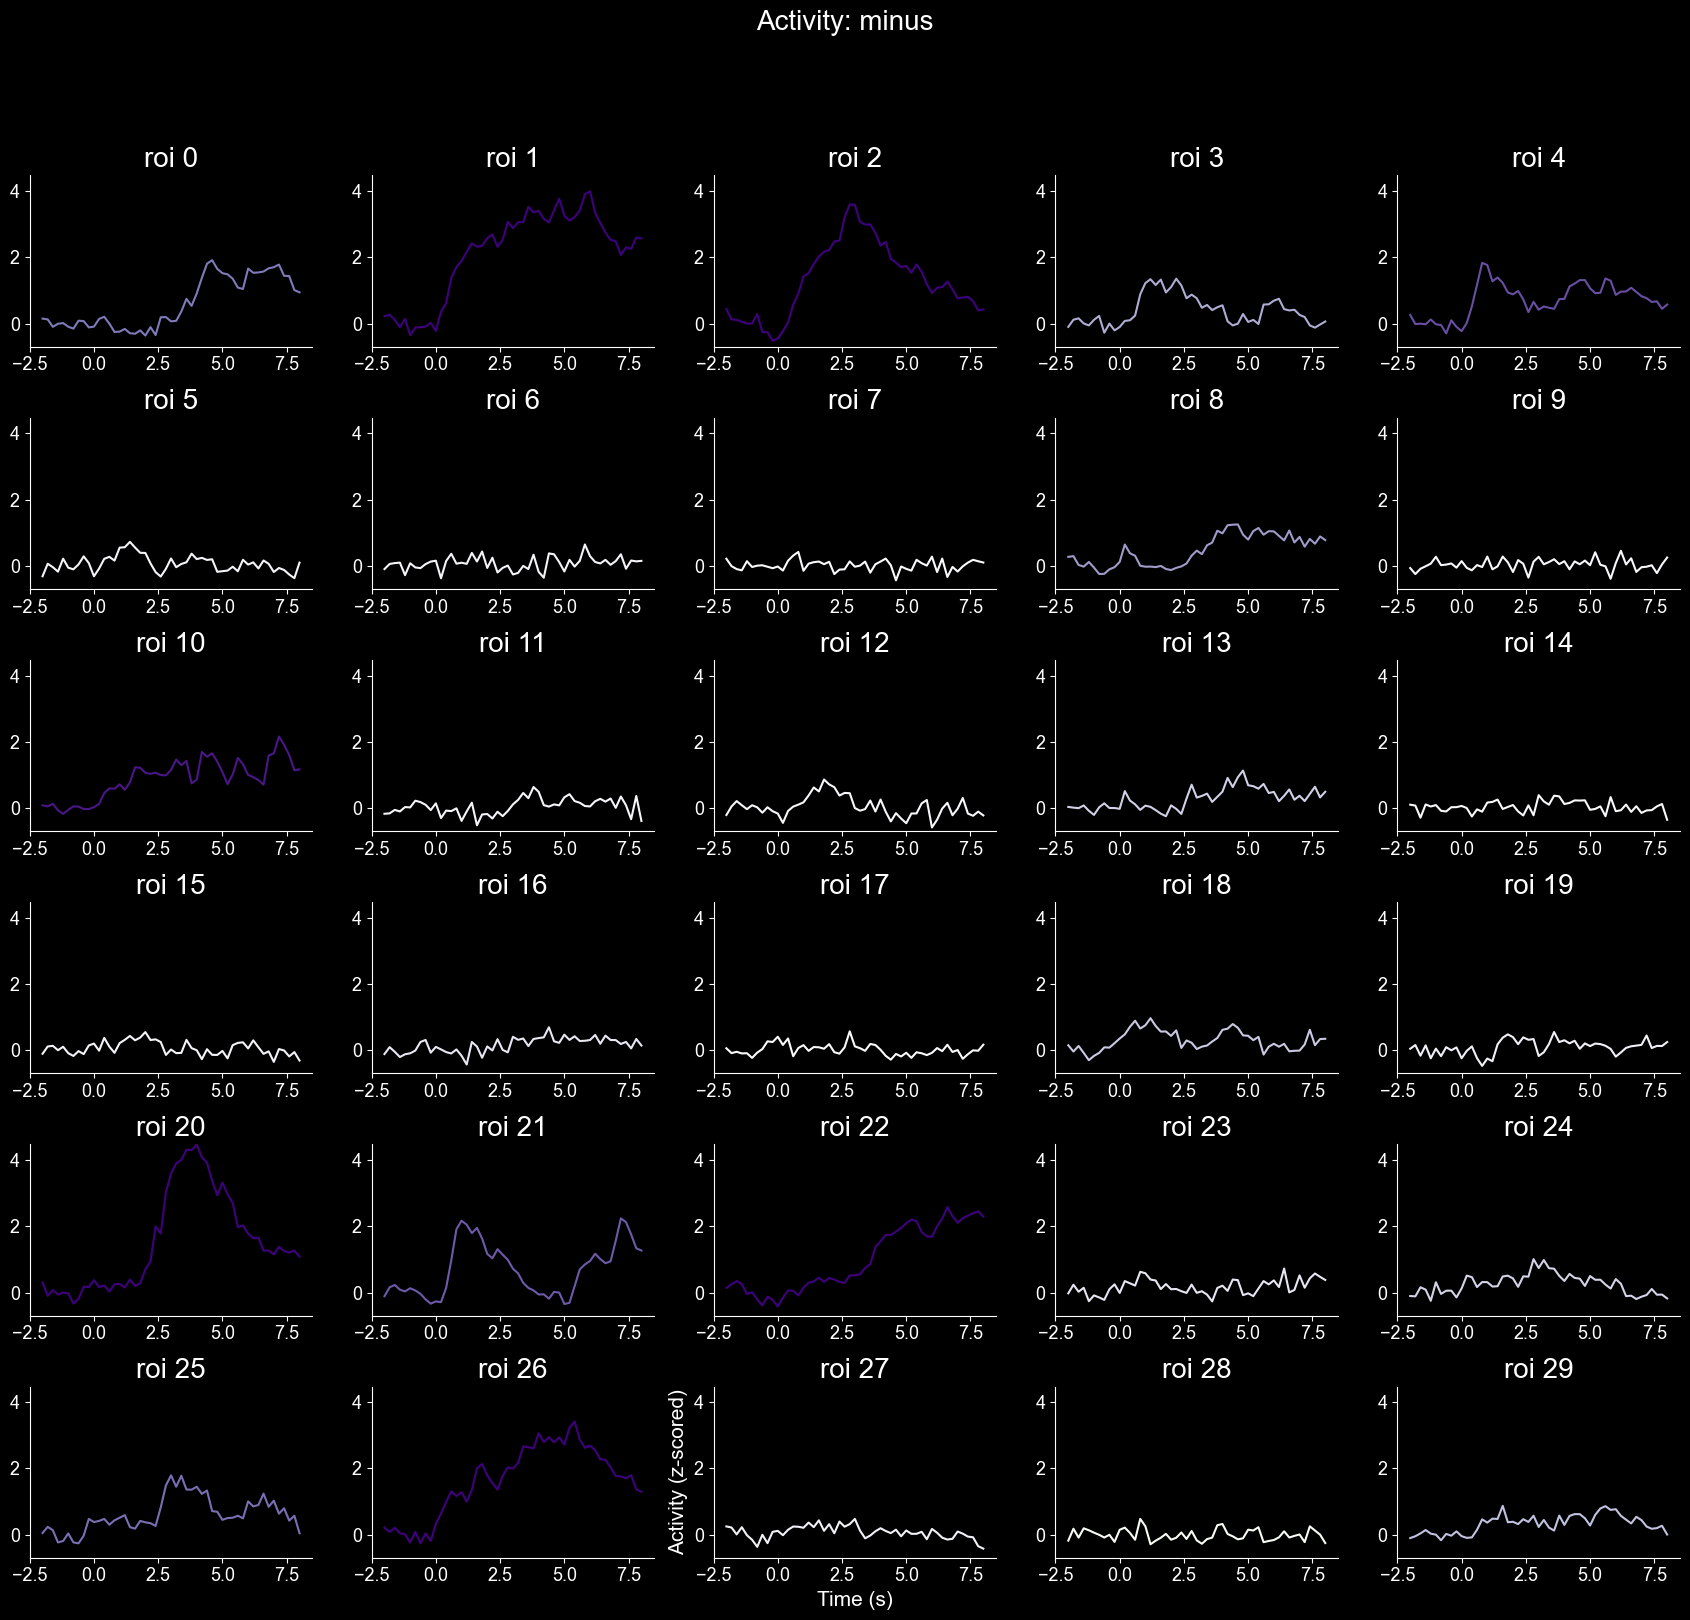

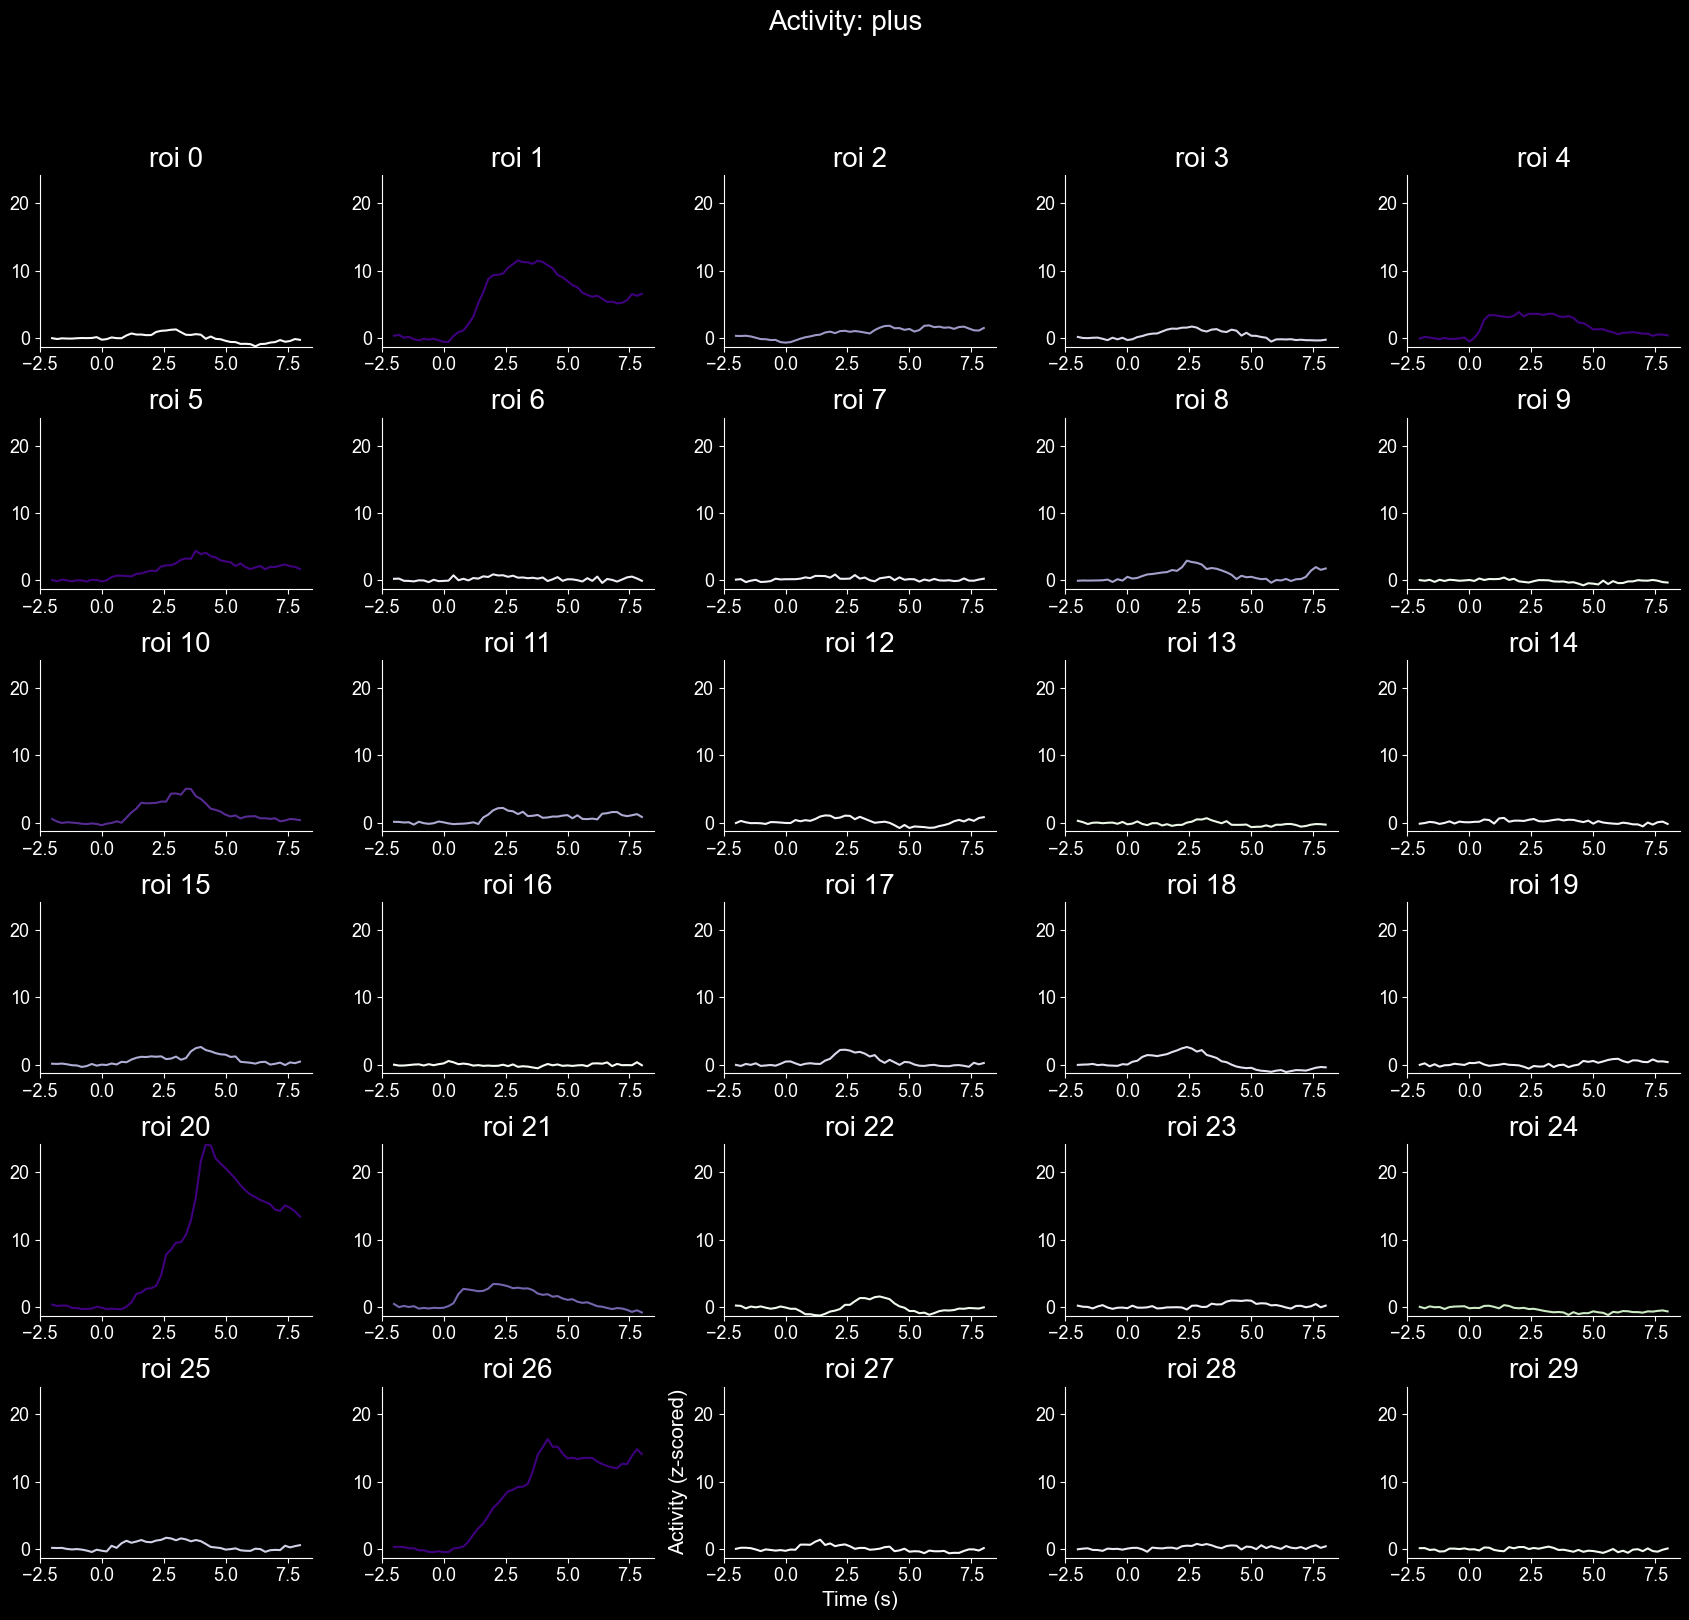

In [218]:
# The main purpose of this function is for sanity check
def plot_activity_subplots(data_dict, analysis_win, name, color_idx):
    """
    A function that takes in a name of an event, and a color index as parameter and
    plot each cell's change of activity corresponding to the specified event across a
    certain time frame as subplots
    """
    
    tvec = np.linspace(-2, 8, data_dict[name]['num_samples'])
    trial_avg_data = np.mean(data_dict[name]['zdata'], axis=0)
    min_max = [np.min(trial_avg_data), np.max(trial_avg_data)]

    contour_vector, orig_vector = generate_contour_vectors(data_dict, analysis_win, name)
    norm, sm = generate_norm_map(orig_vector)
    
    # Set the background color of the plot to black
    plt.style.use('dark_background')

    # Plotting each cell's activity as subplots and color each plot based on the cell's
    # activity value
    (fig, axs) = plt.subplots(nrows=6, ncols=5, figsize=(17, 17))
    fig.suptitle("Activity: " + name + "\n", fontsize=20, color='white')  # Set title color

    counter = 0
    for i in range(6):  # CZ hardcode
        for j in range(5):
            color = sm.to_rgba(orig_vector[counter])  # Get color based on activity value
            roi_color = color[:3]
            
            axs[i, j].plot(tvec, trial_avg_data[counter,:], color=roi_color)
            axs[i, j].set_title("roi " + str(counter), size=20, color='white')  # Set title color
            counter += 1
            axs[i, j].tick_params(axis='both', which='major', labelsize=13, colors='white')  # Set tick label color
            axs[i, j].tick_params(axis='both', which='minor', labelsize=13, colors='white')  # Set tick label color
            axs[i, j].set_ylim(min_max)
            if i == 5 and j == 2:
                axs[i, j].set_xlabel('Time (s)', size=15, color='white')  # Set label color
                axs[i, j].set_ylabel('Activity (z-scored)', size=15, color='white')  # Set label color
            axs[i, j].spines['right'].set_visible(False)
            axs[i, j].spines['top'].set_visible(False)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the position of the suptitle

    # Set the styles of the plot back to normal
    plt.style.use('default')
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt.rcParams["font.family"] = "Arial"

# Call the function for each condition
for i in range(len(conditions)):
    plot_activity_subplots(data_dict, analysis_win, conditions[i], 0)

### Running the last cell more than once will result in errors due to change of data. If you want to run the last cell for the second time, you have to go back to this cell below and start running the cells from here.

In [219]:
def normalize_vector(vector):
    """
    A function that accepts a data vector as parameter and normalize
    its values in order to make them meaningful indices for coloring purposes
    """
    for i in rois_to_include:
        vector[i] = abs(vector[i])
        vector[i] *= 80
        if (vector[i] >= 255):
            vector[i] = 255

In [220]:
def plot_bars(axs, roi_idx, event_names, data, error_events, bar_width, x_positions):
    """
    A function that takes a matplotlib axes object, an axes index, an roi index, event names,
    a pandas dataframe, and error events as parameters. It plots each cell's activity values
    corresponding to each event as a barplot and returns the bar container objects.
    """
    barlist = []

    for j, event_name in enumerate(event_names):
        event_data = data[event_name][roi_idx]
        bars = axs.bar(x_positions + j * bar_width, event_data, bar_width, label=event_name)
        barlist.append(bars)
        
    return barlist

In [221]:
def add_colors(bars, color_idx, data_event, vector):
    """
    A function that takes in a matplotlib axes object, tuples of matplotlib containers,
    color indices to the color schemes, event names, data vectors and a boolean
    that indicates whether or not we are handling the first half of the data as parameters.
    It adds colors to each bar in the barplot based on the cell's activity value corresponds to
    the specified events using the color schemes defined above
    """
    
    for i in range(len(bars[0])):
        for j, event_name in enumerate(conditions):
            bars[j][i].set_color(gpcolors[0][int(vector[j][i])])

In [222]:
def add_text(axs, roi_idx, event_names, x_positions):
    """
    A function that takes a matplotlib axes object, an integer index for color schemes,
    event names and a boolean that indicates whether or not we are handling the
    first half of the data as parameters. It adds texts onto the barplot that indicates
    each cell's activity value;
    """

    for j, event_name in enumerate(event_names):
        prev_heights = []
        for i, v in zip(x_positions, data[event_name][roi_idx]):
            if v < 0:
                v *= -1
            axs.text(i + bar_width * j, v + 0.02, str(round(v, 2)),
                color='black', fontweight='bold', fontsize=12,
                ha='center', va='bottom')  # Adjust text position here

In [223]:
def split_given_size(data, size):
    return np.split(data, np.arange(size,len(data),size))

In [224]:
# Getting the data vector corresponds to the specified event from the dictionary
contour_vector_events = []
error_events = []

data = {}
data['rois'] = [('roi' + str(iroi)) for iroi in rois_to_include]

for event_name in conditions:
    contour_vector = np.mean(data_dict[event_name]['zdata'][:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], axis=(0,2))
    contour_vector_events.append(contour_vector)

    data[event_name] = list(contour_vector)
    normalize_vector(contour_vector)
    
    error_events.append(np.std(np.mean(data_dict[event_name]['zdata']
                                        [:,:,utils.get_tvec_sample(tvec, analysis_win[0]):utils.get_tvec_sample(tvec, analysis_win[-1])], 
                                        axis=2), axis=0) / math.sqrt(data_dict[event_name]['zdata'].shape[0]))

# turn the dictionary into a pandas dataframe
data = pd.DataFrame(data=data)

In [225]:
num_rois_per_subplot = 8
bar_width = 0.2

num_subplots = int(np.ceil(float(num_rois_to_include)/float(num_rois_per_subplot)))
subplot_rois = split_given_size(np.arange(num_rois_to_include),num_rois_per_subplot)

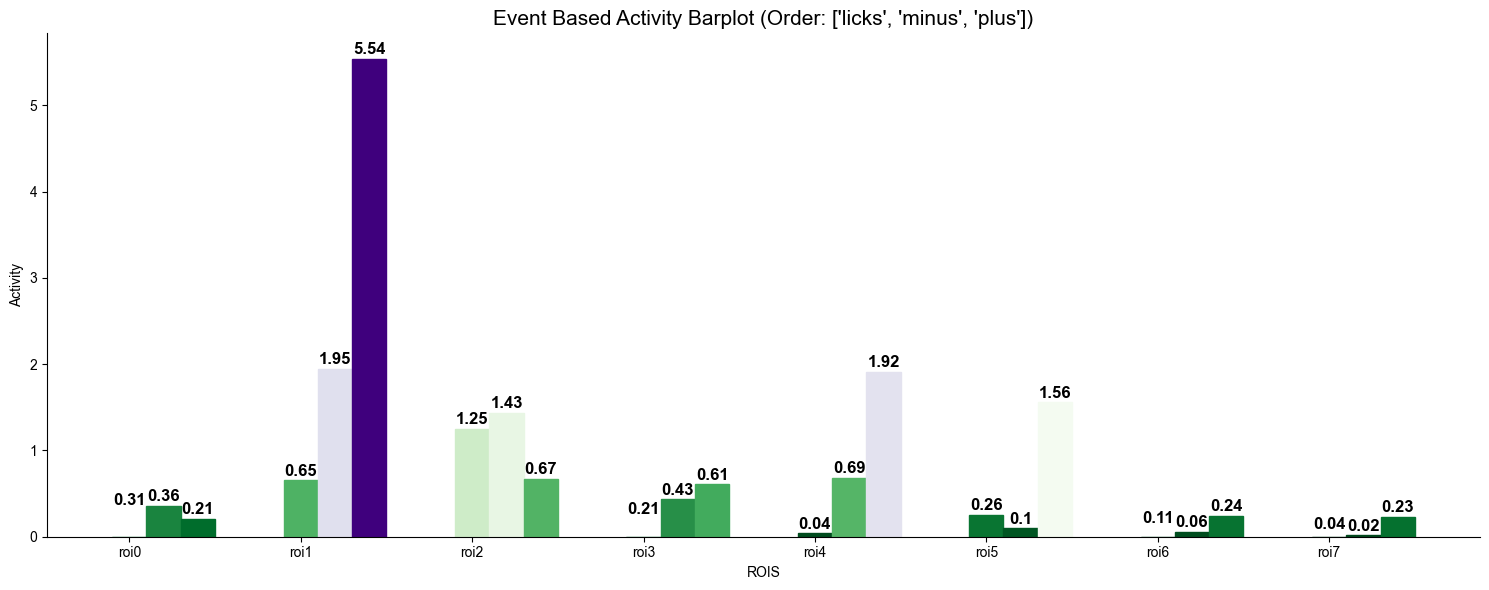

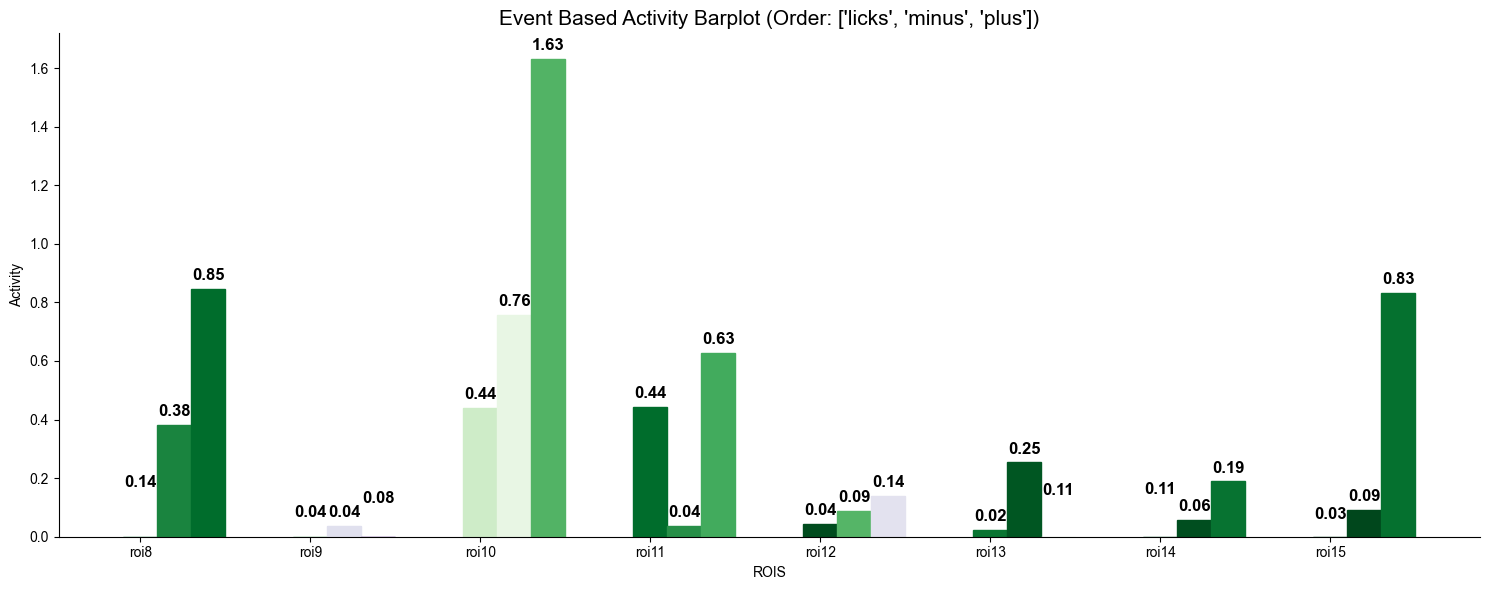

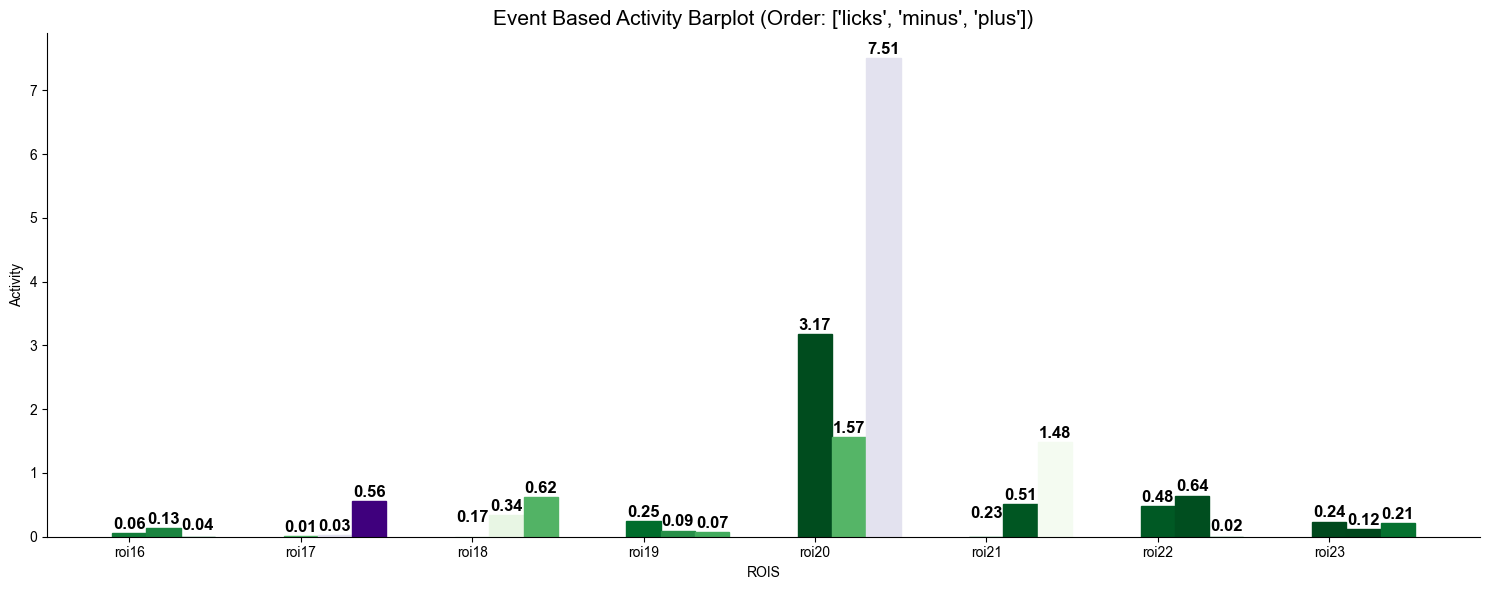

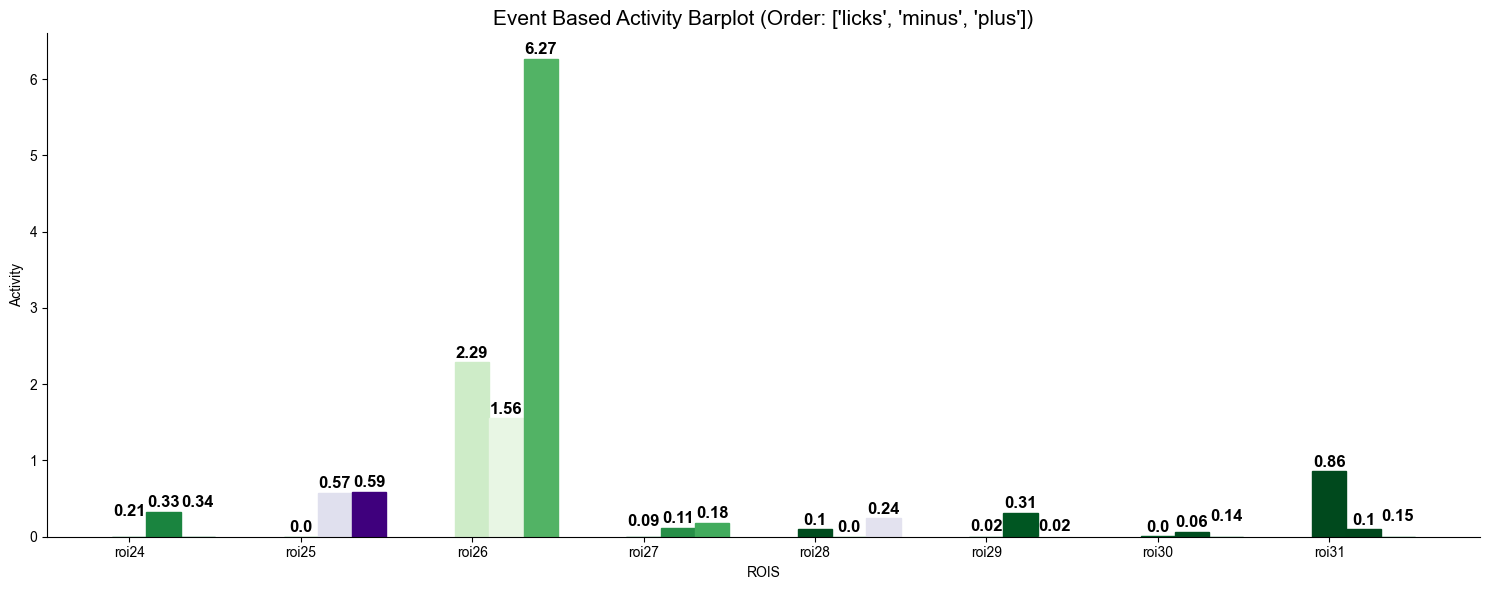

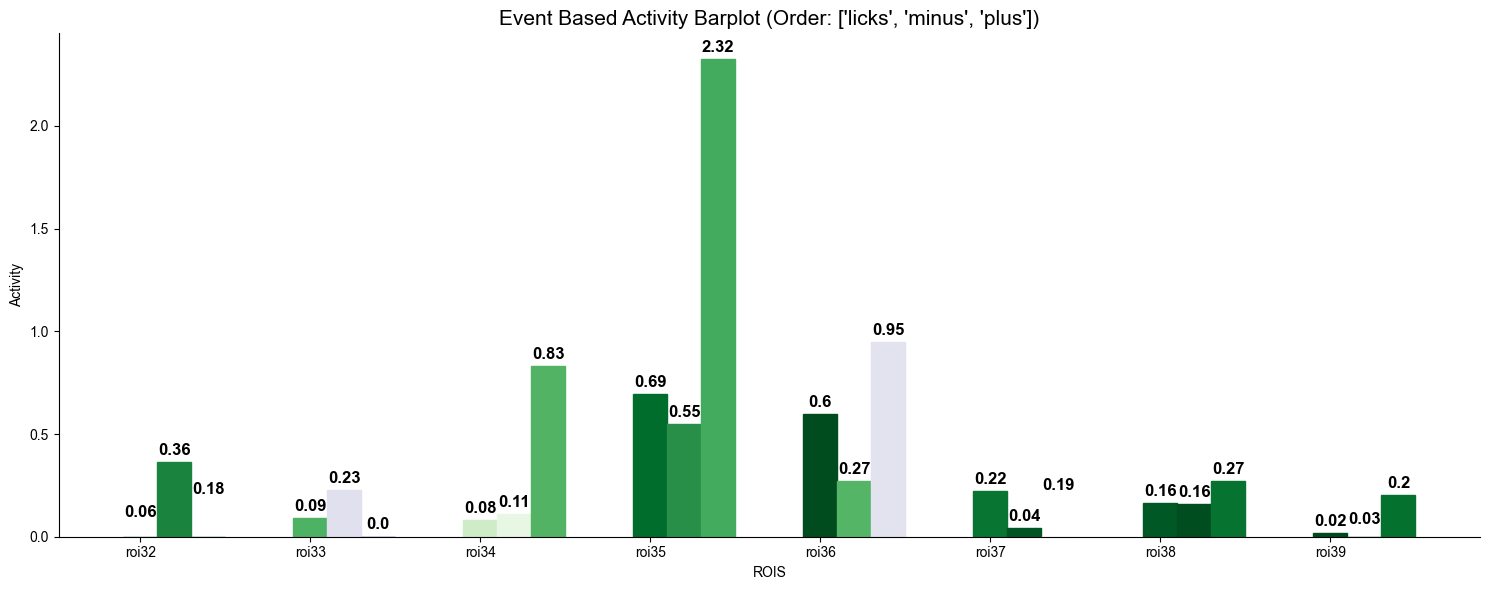

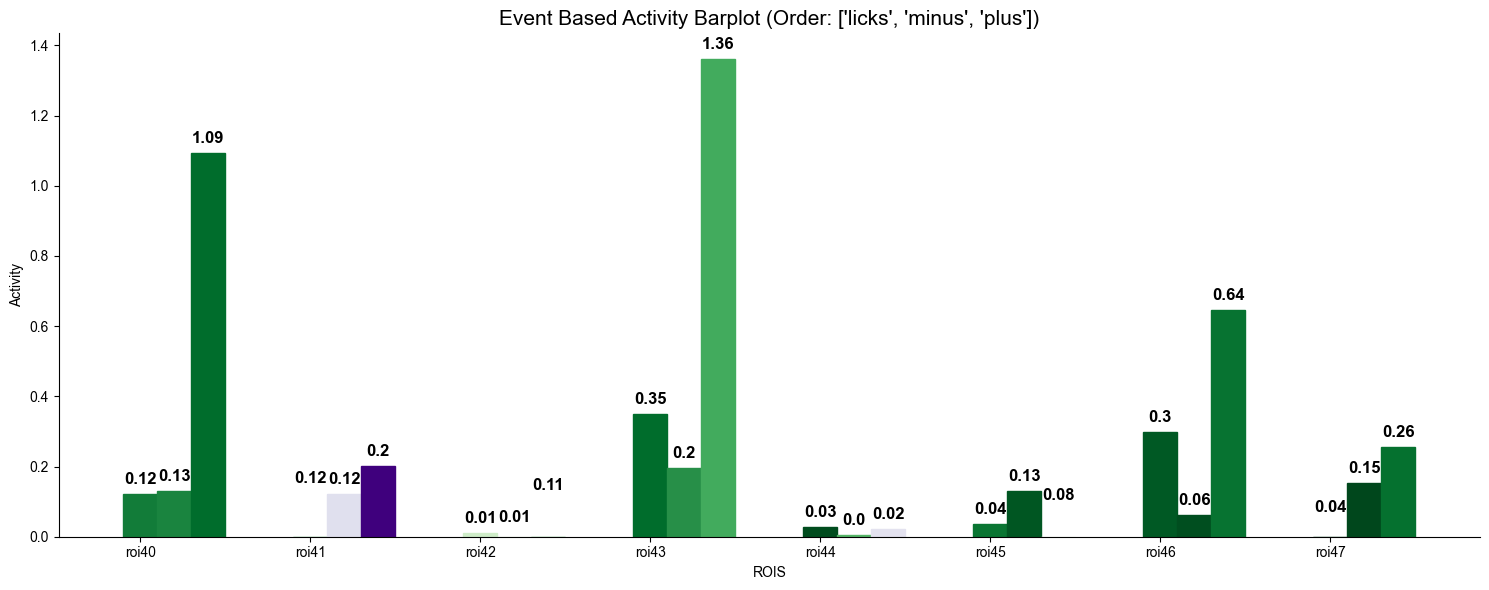

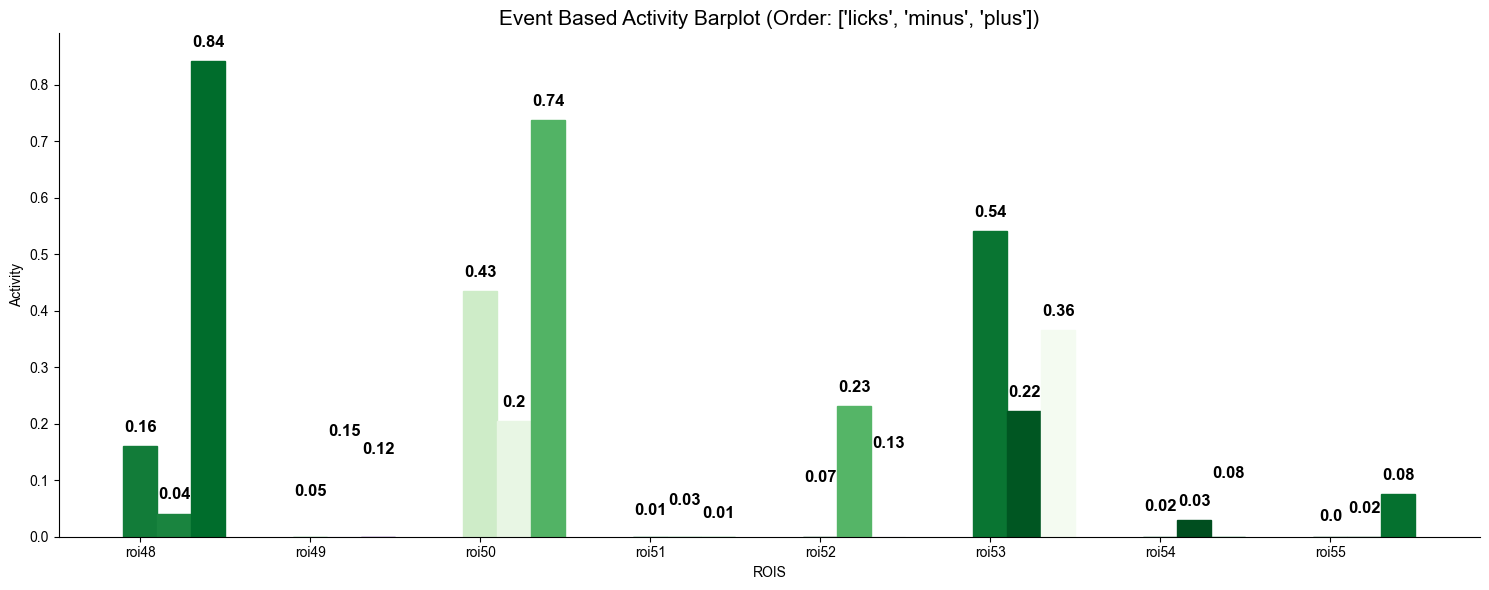

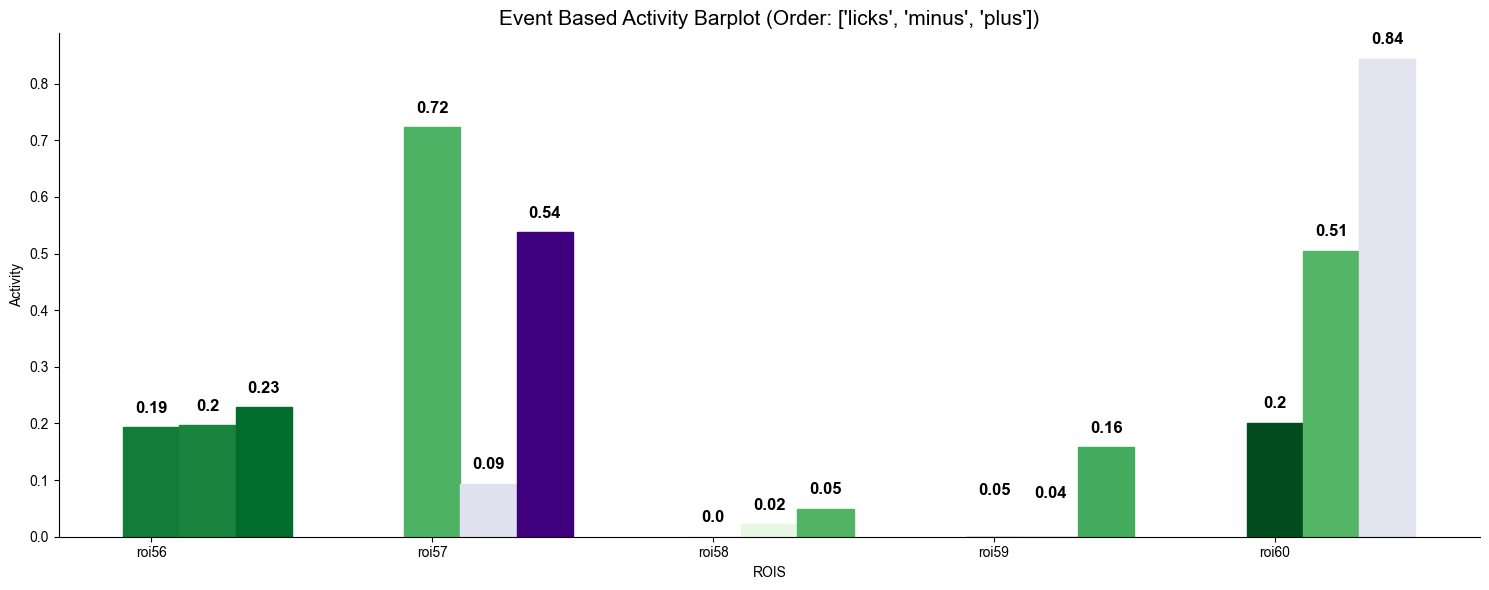

In [226]:
# Plot the barplot for the data and add text
for i in range(num_subplots):
    fig, ax = plt.subplots(figsize=(15, 6))
    
    x_positions = np.arange(len(subplot_rois[i]))
    bars = plot_bars(ax, subplot_rois[i], conditions, data, error_events, bar_width, x_positions)
    add_text(ax, subplot_rois[i], conditions, x_positions)
    add_colors(bars, i, data, contour_vector_events)

    # Decorate the barplot
    placement = float(float(float(bar_width) * len(conditions)) / 2.0)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(data['rois'][subplot_rois[i]], fontsize=10)
    ax.set_title("Event Based Activity Barplot (Order: " + str(conditions) + ")", fontsize=15)
    ax.set_xlabel("ROIS", fontsize=10)
    ax.set_ylabel("Activity", fontsize=10)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylim(bottom=0)
    
    fig.tight_layout()
    plt.show()